In [1]:
# Import packages
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib as mpl 
from scipy.integrate import odeint
import seaborn as sns

colors=sns.color_palette("Set2")
sns.palplot(sns.color_palette("Set2"))

# Figure Size Setting
def set_fig_size(fig_width_pt,nrow=1,ncol=1):
    #Ysize_over_Xsize=(np.sqrt(5)-1)/2
    Ysize_over_Xsize=3/4

    fig_width_in = fig_width_pt/72.27
    
    fig_height_in=fig_width_in*Ysize_over_Xsize*(nrow/ncol)
    fig_dim = (fig_width_in, fig_height_in)
    return fig_dim

# these numbers come from the latex document
# using the commands 
#\showthe\columnwidth
# \showthe\textwidth
colwidth=229.5
textwidth=469


%matplotlib inline

# FIGURE STYLING
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

mpl.rcParams['axes.linewidth'] = 0.5 
mpl.rcParams['xtick.major.size'] = 3
mpl.rcParams['ytick.major.size'] = 3

mpl.rcParams['xtick.major.width'] = 0.5
mpl.rcParams['ytick.major.width'] = 0.5

mpl.rcParams['xtick.minor.size'] = 0


mpl.rcParams['axes.titlesize'] = 10
mpl.rcParams['axes.labelsize'] = 9
mpl.rcParams['xtick.labelsize'] = 6
mpl.rcParams['ytick.labelsize'] = 6
mpl.rcParams['legend.fontsize'] = 7
mpl.rcParams['font.family'] = ['sans-serif']
mpl.rc('font',**{'family':'sans-serif','sans-serif':['Arial']})

# FIGURE 4

In [2]:
def CV2intY(par, tot, sig):
    k1, k2, k3, k4, k5, k6 = par
    XT, YT = tot
    S=sig
    num = k4 + k6*(k2*XT)/(k1*S+k2)
    den =YT*(k3 + k5*(k1*S*XT)/(k1*S+k2))
    return num/den

def CV2intX(par, tot, sig):
    k1, k2, k3, k4, k5, k6 = par
    XT, YT = tot
    S=sig
    num = k2
    den =XT*k1*S
    return num/den

def timeavg(par, tot, sig):
    k1, k2, k3, k4, k5, k6 = par
    XT, YT = tot
    S=sig
    Txinv = k1*S+k2
    TySinv=k3+k4+k5*k1*S*XT/(k1*S+k2)+k6*k2*XT/(k1*S+k2)
    return TySinv/(Txinv+TySinv)

def coupling(par, tot, sig):
    k1, k2, k3, k4, k5, k6 = par
    XT, YT = tot
    S=sig
    num1=k1*S*XT/(k1*S+k2)
    num2=k4*k5+k6*(k3+k5*XT)
    den1=k3 + k5*k1*S*XT/(k1*S+k2)
    den2=k3+k4+k5*k1*S*XT/(k1*S+k2)+k6*k2*XT/(k1*S+k2)
    valsqrt=num1*num2/(den1*den2)
    return valsqrt**2

def CVtotY(par, tot, sig):
    k1, k2, k3, k4, k5, k6 = par
    XT, YT = tot
    S=sig
    CVintrinsic=CV2intX(par,tot,sig)
    tavg=timeavg(par,tot,sig)
    susceptibility = coupling(par,tot,sig)
    CVupstream=CV2intX(par,tot,sig)
    tot = CVintrinsic + tavg*susceptibility*CVupstream
    if np.abs(k5-k6)<1e-10:
        # if k5=k6, perfect concerted model
        tot = CVintrinsic + ((YT-1)/YT)*tavg*susceptibility*CVupstream
    return tot


def meanY(par,tot,sig):
    k1, k2, k3, k4, k5, k6 = par
    XT, YT = tot
    S=sig
    num=YT*(k3+k5*k1*S*XT/(k1*S+k2))
    den=k3+k4+k5*k1*S*XT/(k1*S+k2)+k6*k2*XT/(k1*S+k2)
    return num/den
    

def makeA0matrix(par, tot, sig):
    XT=tot[0]
    k1, k2 = par[0], par[1]
    A0diag=[-k1*sig*(XT-i)-k2*i for i in range(0,XT+1)]
    A0diag1p=[k2*(i+1) for i in range(0,XT)]
    A0diag1n=[k1*sig*(XT-i+1) for i in range(1,XT+1)]
    A0 = np.diag(A0diag,0)+np.diag(A0diag1p,1)+np.diag(A0diag1n,-1)
    return A0


def mu0SteadyState(par,tot,sig):
    XT=tot[0]
    A0=makeA0matrix(par, tot, sig)
    A0_red=A0[0:-1,0:-1]
    bXT_coeff = A0[-2,-1] # this was the term from b_{X_T} coming to b_{X_T-1}
    A0_add = np.zeros((XT,XT))
    A0_add[-1,:] = - bXT_coeff * np.ones(XT) 
    # this is a result of substituting b_{X_T} = 1 - sum_{i=0}^{X_T-1} b_i, without 1
    c = np.zeros(XT) # 1 is substituted here
    c[-1] = - bXT_coeff # this is from  1
    A0_tilde = A0_red + A0_add
    mu0SS_except_bXT=np.linalg.solve(A0_tilde, c)
    mu0SS = np.append(mu0SS_except_bXT,1-np.sum(mu0SS_except_bXT))
    return mu0SS


def makeA10A11matrix(par, tot, sig):
    XT=tot[0]
    RT=tot[1]
    k1, k2, k3, k4, k5, k6 = par
    
    A10diag = [k3*RT + k5*RT*i for i in range(0,XT+1)]

    A11diag=[-k1*sig*(XT-i)-k2*i - k3 - k4 - k5*i - k6*(XT-i) for i in range(0,XT+1)]
    A11diag1p=[k2*(i+1) for i in range(0,XT)]
    A11diag1n=[k1*sig*(XT-i+1) for i in range(1,XT+1)]
    
    A10 = np.diag(A10diag,0)
    A11 = np.diag(A11diag,0)+np.diag(A11diag1p,1)+np.diag(A11diag1n,-1)
        
    return A10, A11

def mu1SteadyState(par,tot,sig):
    mu0SS=mu0SteadyState(par,tot,sig)
    A10,A11=makeA10A11matrix(par, tot, sig)
    mu0_term= - np.dot(A10,mu0SS)
    mu1SS=np.linalg.solve(A11, mu0_term)
    return mu0SS, mu1SS

def mu1SteadyStateSum(par,tot,sig):
    mu0SS,mu1SS = mu1SteadyState(part,tot,sig)
    mu0_ss_sum=np.sum(mu0SS)
    mu1_ss_sum=np.sum(mu1SS)
    return mu0_ss_sum, mu1_ss_sum





def makeA20A21A22matrix(par, tot, sig):
    XT=tot[0]
    RT=tot[1]
    k1, k2, k3, k4, k5, k6 = par
    
    A20diag = [k3*RT + k5*RT*i for i in range(0,XT+1)]
    
    A21diag = [-k3-k5*i+k4+k6*XT-k6*i+2*k3*RT+2*k5*RT*i for i in range(0,XT+1)]

    A22diag=[-k1*sig*(XT-i)-k2*i - 2*k3 - 2*k4 - 2*k5*i - 2*k6*(XT-i) for i in range(0,XT+1)]
    
    A22diag1p=[k2*(i+1) for i in range(0,XT)]
    
    A22diag1n=[k1*sig*(XT-i+1) for i in range(1,XT+1)] 
    
    
    A20 = np.diag(A20diag,0)
    A21 = np.diag(A21diag,0)
    A22 = np.diag(A22diag,0)+np.diag(A22diag1p,1)+np.diag(A22diag1n,-1)
        
    return A20, A21, A22

def mu2SteadyState(par,tot,sig):
    mu0SS, mu1SS=mu1SteadyState(par,tot,sig)
    A20,A21,A22=makeA20A21A22matrix(par, tot, sig)
    mu0_term= - np.dot(A20,mu0SS)
    mu1_term = - np.dot(A21, mu1SS)
    mu2SS=np.linalg.solve(A22, mu0_term+mu1_term)
    return mu0SS, mu1SS, mu2SS


def mu2SteadyStateSum(par,tot,sig):
    mu0SS,mu1SS,mu2SS = mu2SteadyState(par,tot,sig)
    mu0_ss_sum=np.sum(mu0SS)
    mu1_ss_sum=np.sum(mu1SS)
    mu2_ss_sum=np.sum(mu2SS)
    return mu0_ss_sum, mu1_ss_sum, mu2_ss_sum


# activation parameters
k1Soverk2=1
S=1
TxratioList=np.logspace(-2,2,101)

XTact=100
YTact=100

k3act=0
k4act=1
k5act=2/XTact
k6act=0



k2actList=[(k3act+k4act+k5act*k1Soverk2*XTact/(1+k1Soverk2)+k6act*XTact/(1+k1Soverk2))/(txval*(1+k1Soverk2))
          for txval in TxratioList]

mactLNA=[]
mactExact=[]
CV2actLNA=[]
CV2actExact=[]



for k2act in k2actList:
    k1act=k1Soverk2*k2act/S
    
    cvintrinsic = CV2intY([k1act,k2act,k3act,k4act,k5act,k6act],[XTact,YTact],S)
  
    mapprox=meanY([k1act,k2act,k3act,k4act,k5act,k6act],[XTact,YTact],S)
    cvapprox=CVtotY([k1act,k2act,k3act,k4act,k5act,k6act],[XTact,YTact],S)
    mactLNA.append(mapprox)
    CV2actLNA.append(cvapprox/cvintrinsic)
    
    mu0_ss_sum, mu1_ss_sum, mu2_ss_sum = mu2SteadyStateSum([k1act,k2act,k3act,k4act,k5act,k6act],[XTact,YTact],S)
    cvexact = -1 + mu2_ss_sum/mu1_ss_sum**2
    
    
    mactExact.append(mu1_ss_sum)
    CV2actExact.append(cvexact/cvintrinsic)
    
    

#derepression    
XTderep=100
YTderep=100

k3derep=1
k4derep=0
k5derep=0
k6derep=2/XTderep



k2derepList=[(k3derep+k4derep+k5derep*k1Soverk2*XTderep/(1+k1Soverk2)+k6derep*XTderep/(1+k1Soverk2))/(txval*(1+k1Soverk2))
          for txval in TxratioList]

mderepLNA=[]
mderepExact=[]
CV2derepLNA=[]
CV2derepExact=[]

for k2derep in k2derepList:
    k1derep=k1Soverk2*k2derep/S
    
    cvintrinsic = CV2intY([k1derep,k2derep,k3derep,k4derep,k5derep,k6derep],[XTderep,YTderep],S)

    
    mapprox=meanY([k1derep,k2derep,k3derep,k4derep,k5derep,k6derep],[XTderep,YTderep],S)

    cvapprox=CVtotY([k1derep,k2derep,k3derep,k4derep,k5derep,k6derep],[XTderep,YTderep],S)
    
    mderepLNA.append(mapprox)
    CV2derepLNA.append(cvapprox/cvintrinsic)
    
    mu0_ss_sum, mu1_ss_sum, mu2_ss_sum = mu2SteadyStateSum([k1derep,k2derep,k3derep,k4derep,k5derep,k6derep],
                                                           [XTderep,YTderep],S)
    mexact=mu1_ss_sum
    cvexact = -1 + mu2_ss_sum/mu1_ss_sum**2
    

    
    mderepExact.append(mexact)
    CV2derepExact.append(cvexact/cvintrinsic)
        


#derepression    
XTconc=100
YTconc=100

k3conc=0
k4conc=0
k5conc=2/XTconc
k6conc=2/XTconc



k2concList=[(k3conc+k4conc+k5conc*k1Soverk2*XTconc/(1+k1Soverk2)+k6conc*XTconc/(1+k1Soverk2))/(txval*(1+k1Soverk2))
          for txval in TxratioList]
    
mconcLNA=[]
mconcExact=[]
CV2concLNA=[]
CV2concExact=[]

for k2conc in k2concList:
    k1conc=k1Soverk2*k2conc/S
    
    cvintrinsic = CV2intY([k1conc,k2conc,k3conc,k4conc,k5conc,k6conc],[XTconc,YTconc],S)

    
    mapprox=meanY([k1conc,k2conc,k3conc,k4conc,k5conc,k6conc],[XTconc,YTconc],S)
    cvapprox=CVtotY([k1conc,k2conc,k3conc,k4conc,k5conc,k6conc],[XTconc,YTconc],S)
    mconcLNA.append(mapprox)
    CV2concLNA.append(cvapprox/cvintrinsic)
    
    
    mu0_ss_sum, mu1_ss_sum, mu2_ss_sum = mu2SteadyStateSum([k1conc,k2conc,k3conc,k4conc,k5conc,k6conc],
                                                           [XTconc,YTconc],S)
    mexact = mu1_ss_sum
    cvexact = -1 + mu2_ss_sum/mu1_ss_sum**2
    

    
    mconcExact.append(mexact)
    
    CV2concExact.append(cvexact/cvintrinsic)

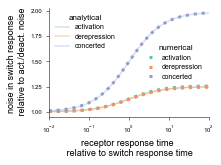

In [3]:
# this figure is full-width, which is 469 pts. may be different for PNAS 
#fig = plt.figure(figsize=set_fig_size(textwidth,1,3))

fig,ax=plt.subplots(figsize=set_fig_size(colwidth,1,1))


# Analytical
ax.semilogx(TxratioList,CV2actLNA,color=colors[0],alpha=0.35,label='activation')
ax.semilogx(TxratioList,CV2derepLNA,color=colors[1],alpha=0.35,label='derepression')
ax.semilogx(TxratioList,CV2concLNA,color=colors[2], alpha=0.35,label='concerted')

# Numerical validation
cv2_act_num,=ax.semilogx(TxratioList,CV2actExact,linestyle=':',linewidth=3,color=colors[0])
cv2_derep_num,=ax.semilogx(TxratioList,CV2derepExact,linestyle=':',linewidth=3,color=colors[1])
cv2_conc_num,=ax.semilogx(TxratioList,CV2concExact,linestyle=':',linewidth=3,color=colors[2])


legend1=ax.legend(loc='upper left',title='analytical',frameon=False,fontsize=7)
legend2=ax.legend([cv2_act_num,cv2_derep_num,cv2_conc_num],['activation','derepression','concerted'], 
                  title='numerical',fontsize=7,frameon=False,handlelength=1,loc='center right')

title1 = legend1.get_title()
title1.set_fontsize(8)

title2 = legend2.get_title()
title2.set_fontsize(8)

#legend2lw=legend2.get_lines()
#legend2lw[0].set_linewidth(2)
#legend2lw[1].set_linewidth(2)
#legend2lw[2].set_linewidth(2)


ax.add_artist(legend1)


ax.set_xlabel('receptor response time \n relative to switch response time')
ax.set_ylabel('noise in switch response \n relative to act./deact. noise')

ax.set_xlim(1e-2,1e2)
ax.set_yticks([1.0, 1.25, 1.5, 1.75, 2.0])
ax.set_xticks([1e-2,1e-1, 1e0, 1e1,1e2])


plt.tight_layout()

#plt.savefig('../fig_pdfs_for_paper/fig4.pdf',bbox_inches = 'tight', pad_inches = 0)

# FIGURE 4 TWO PANELS

## Figure panel B material

In [4]:
# Activation parameters


k1act=1
k2act=1
S=1
XTact=100
YTact=100
Xssact=k1act*S*XTact/(k1act*S+k2act)

k4act=0
k6act=1/(XTact-Xssact) # to ensure that k4+k6act*(XT-Xssact)=1
rhoactList=np.logspace(-2,0,101) 
# ratio k5/k6. Note that it can be maximum 1, when k3 would be zero and all fwd rate is k3
# here we've set k3+k5*Xss = 1. k4+k6*(XT-Xss)=1 and we set k4act=0

k5actList=k6act*rhoactList


B_mactLNA=[]
B_mactExact=[]
B_CV2actLNA=[]
B_CV2actExact=[]



for k5act in k5actList:
    k3act=1-k5act*Xssact
    
    cvintrinsic = CV2intY([k1act,k2act,k3act,k4act,k5act,k6act],[XTact,YTact],S)
  
    mapprox=meanY([k1act,k2act,k3act,k4act,k5act,k6act],[XTact,YTact],S)
    cvapprox=CVtotY([k1act,k2act,k3act,k4act,k5act,k6act],[XTact,YTact],S)
    B_mactLNA.append(mapprox)
    B_CV2actLNA.append(cvapprox/cvintrinsic)
    
    mu0_ss_sum, mu1_ss_sum, mu2_ss_sum = mu2SteadyStateSum([k1act,k2act,k3act,k4act,k5act,k6act],[XTact,YTact],S)
    cvexact = -1 + mu2_ss_sum/mu1_ss_sum**2
    
    
    B_mactExact.append(mu1_ss_sum)
    B_CV2actExact.append(cvexact/cvintrinsic)
    

# DEREPRESSION PARAMETERS    
k1rep=1
k2rep=1
S=1
XTrep=100
YTrep=100
Xssrep=k1rep*S*XTrep/(k1rep*S+k2rep)

k3rep=0
k5rep=1/Xssrep # to ensure that k3+k5*Xss=1.

# activation parameters
rhorepList=np.logspace(0,2,101) 
# ratio k5/k6. Note that it can be maximum 1, when k4 would be zero and all bwd rate is k6
# here we've set k3+k5*Xss = 1. k4+k6*(XT-Xss)=1 and we set k4act=0

k6repList=k5rep/rhorepList


B_mrepLNA=[]
B_mrepExact=[]
B_CV2repLNA=[]
B_CV2repExact=[]



for k6rep in k6repList:
    k4rep=1-k6rep*(XTrep-Xssrep)
    
    cvintrinsic = CV2intY([k1rep,k2rep,k3rep,k4rep,k5rep,k6rep],[XTrep,YTrep],S)
  
    mapprox=meanY([k1rep,k2rep,k3rep,k4rep,k5rep,k6rep],[XTrep,YTrep],S)
    cvapprox=CVtotY([k1rep,k2rep,k3rep,k4rep,k5rep,k6rep],[XTrep,YTrep],S)
    B_mrepLNA.append(mapprox)
    B_CV2repLNA.append(cvapprox/cvintrinsic)
    
    mu0_ss_sum, mu1_ss_sum, mu2_ss_sum = mu2SteadyStateSum([k1rep,k2rep,k3rep,k4rep,k5rep,k6rep],[XTrep,YTrep],S)
    cvexact = -1 + mu2_ss_sum/mu1_ss_sum**2
    
    
    B_mrepExact.append(mu1_ss_sum)
    B_CV2repExact.append(cvexact/cvintrinsic)


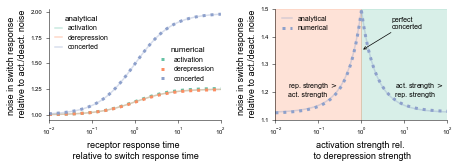

In [5]:
fig=plt.figure(figsize=set_fig_size(textwidth,1,2))

gs = mpl.gridspec.GridSpec(1,2)

A = fig.add_subplot(gs[0,0])
B = fig.add_subplot(gs[0,1])



# Analytical
A.semilogx(TxratioList,CV2actLNA,color=colors[0],alpha=0.35,label='activation')
A.semilogx(TxratioList,CV2derepLNA,color=colors[1],alpha=0.35,label='derepression')
A.semilogx(TxratioList,CV2concLNA,color=colors[2], alpha=0.35,label='concerted')

# Numerical validation
cv2_act_num,=A.semilogx(TxratioList,CV2actExact,linestyle=':',linewidth=3,color=colors[0])
cv2_derep_num,=A.semilogx(TxratioList,CV2derepExact,linestyle=':',linewidth=3,color=colors[1])
cv2_conc_num,=A.semilogx(TxratioList,CV2concExact,linestyle=':',linewidth=3,color=colors[2])


legend1=A.legend(loc='upper left',title='analytical',frameon=False,handlelength=1,fontsize=7)
legend2=A.legend([cv2_act_num,cv2_derep_num,cv2_conc_num],['activation','derepression','concerted'], 
                  title='numerical',fontsize=7,frameon=False,handlelength=1,loc='center right')

title1 = legend1.get_title()
title1.set_fontsize(8)

title2 = legend2.get_title()
title2.set_fontsize(8)

#legend2lw=legend2.get_lines()
#legend2lw[0].set_linewidth(2)
#legend2lw[1].set_linewidth(2)
#legend2lw[2].set_linewidth(2)


A.add_artist(legend1)


A.set_xlabel('receptor response time \n relative to switch response time')
A.set_ylabel('noise in switch response \n relative to act./deact. noise')

A.set_xlim(1e-2,1e2)
A.set_yticks([1.0, 1.25, 1.5, 1.75, 2.0])
A.set_xticks([1e-2,1e-1, 1e0, 1e1,1e2])



# Activation Numerical and Exact
B.semilogx(rhoactList,B_CV2actLNA,color=colors[2],alpha=0.35,label='analytical')
B.semilogx(rhoactList,B_CV2actExact,linestyle=':',linewidth=3,color=colors[2],label='numerical')

# Numerical
B.semilogx(rhorepList,B_CV2repLNA,color=colors[2],alpha=0.35)
B.semilogx(rhorepList,B_CV2repExact,linestyle=':',linewidth=3,color=colors[2])

B.axvspan(1e0, 1e2, alpha=0.25, color=colors[0])
B.axvspan(1e-2, 1e0, alpha=0.25, color=colors[1])

B.set_xlim(1e-2,1e2)
B.set_ylim(1.1,1.5)
B.set_yticks([1.1,1.2,1.3,1.4,1.5])

B.legend(loc='upper left',frameon=False,handlelength=1.5)

B.annotate('perfect\n'+ 'concerted',
            xy=(1e0,1.35), size=7, xycoords='data',
            xytext=(5, 1.43), textcoords='data',
            arrowprops=dict(arrowstyle="->",lw=0.7))
B.set_xlabel('activation strength rel. \n to derepression strength')
B.set_ylabel('noise in switch response \n relative to act./deact. noise')


B.text(6e0,1.18,'act. strength $>$ \n' + 'rep. strength',fontsize=7)

B.text(2e-2,1.18,'rep. strength $>$ \n' + 'act. strength',fontsize=7)


plt.tight_layout()

plt.savefig('../fig_pdfs_for_paper/fig4.pdf',bbox_inches = 'tight', pad_inches = 0)